In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from os import listdir
from PIL import Image
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import os
%matplotlib inline
import sys
if (os.getcwd().split("/")[-1]=="evaluation"):
    os.chdir("../")
import subprocess
import importlib
import shutil
import random
from utils import change_active_config, copy_n_rand_patches
from evaluation import read_tensor_from_image_file, load_graph, load_labels
import constants

In [3]:
def evaluate_and_show(src_dir, model_file, labels_file, input_height = 299,input_width = 299, show=0):

    input_mean = 0
    input_std = 255
    input_layer = "Placeholder"
    output_layer = "final_result"

    files = [os.path.join(src_dir, file) for file in listdir(src_dir)]
   
    graph = load_graph(model_file)
    fig = plt.figure(figsize=(30,20))
    no_of_files = len(files)
    files_to_show = random.sample(files,show)
    for i,f in enumerate(files_to_show):
        t = read_tensor_from_image_file(
              f,
              input_height=input_height,
              input_width=input_width,
              input_mean=input_mean,
              input_std=input_std)

        input_name = "import/" + input_layer
        output_name = "import/" + output_layer
        input_operation = graph.get_operation_by_name(input_name)
        output_operation = graph.get_operation_by_name(output_name)

        with tf.Session(graph=graph) as sess:
            results = sess.run(output_operation.outputs[0], {
                input_operation.outputs[0]: t
            })
        results = np.squeeze(results)
        predic = results.argsort()[::-1]
        labels = load_labels(labels_file)
        
        subplt=fig.add_subplot(np.sqrt(show), np.sqrt(show) ,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        color="green" if (labels[predic[0]].startswith("ben") or labels[predic[0]].startswith("neg")) else "red" 
        subplt.set_xlabel(labels[predic[0]]+" "+str(results[predic[0]]),color=color).set_fontsize(20)
        name = f.split("/")[-1]
        color="green" if name.startswith("neg") else "red" if name.startswith("pos") else "blue"
        subplt.set_title(name,color=color).set_fontsize(22)
        image = imread(f)
        imshow(image)

In [4]:
def retrain_and_evaluate(src_dir_train, src_dir_eval, model, labels, steps, no_imgs_per_class=5000):
    
    if (os.path.exists(src_dir_train + "/tmp_imgs/")):
        shutil.rmtree(src_dir_train + "/tmp_imgs/")
    os.mkdir(src_dir_train+"tmp_imgs/")
    os.mkdir(src_dir_train+"tmp_imgs/positive/")
    os.mkdir(src_dir_train+"tmp_imgs/negative/")
    
    copy_n_rand_patches(src_dir_train+"positive/", src_dir_train + "tmp_imgs/positive/", no_imgs_per_class)
    copy_n_rand_patches(src_dir_train+"negative/", src_dir_train + "tmp_imgs/negative/", no_imgs_per_class)
    
    
    subprocess.call(["python","evaluation/retrain.py",
                     "--image_dir={}".format(src_dir_train + "/tmp_imgs/"),
                     "--how_many_training_steps={}".format(steps),
                     "--output_graph={}".format(model),
                     "--output_labels={}".format(labels),
                     "--print_misclassified_test_images"])
                    
    
    evaluate_and_show(src_dir_eval, model, labels, show = 16)
    
    shutil.rmtree(src_dir_train + "/tmp_imgs/")

Inicialmente realice algunas pruebas con imagenes generadas normales y cancerosas por separado, esto es, entrenaba la red con uno de las clases, generaba ese tipo de imagenes y realizaba un test "inception" consistente en ent

Tipos de pruebas realizadas:

Entrenamiento de la red por separado con parches de celulas normales y con celulas cancerosas por otro 
y realización de un test "inception" : Con un clasificador estado del arte como inception v3 o resnet se realiza un entrenamiento mediante transfer learning con las imagenes reales y luego se mide su rendimiento a la hora de clasificar las imagenes generadas previamente. Al generarlas por separado sabemos a que clase pertenece cada imagen generada.

Inconvenientes de este tipo de pruebas:
No se corresponde con el ambito de este proyecto. En las pruebas con estos clasificadores he obtenido unos valores muy buenos, superiores al 90% clasificando las imagenes falsas en poco tiempo, pero ya hay otros trabajos sobre la capacidad de generar imagenes realistas con DCGANs. 

En este proyecto queremos evaluar las imagenes generadas una vez aplicamos determinadas operaciones sobre los tensores que generan esas imagenes. Para realizar operaciones que incluyan distintas clases, como por ejemplo sumar una cara sonriente con una con gafas, o una celula cancerosa con x caracteristica con otra normal es necesario realizar el entrenamiento de la DCGAN conjuntamente con lo cual este tipo de evaluaciones con un clasificador supervisado no son viables (al no disponer de la clase exacta de cada imagen generada)


## Evaluacion de la red imagenes generadas a partir de la red entrenada con parches extraidos al nivel de zoom 0

In [5]:
dataset = "camelyon_17_16_level0"
change_active_config(dataset)
importlib.reload(constants)

<module 'constants' from '/home/ruben/Repositories/histo_bkp/histology_dcgan/constants.py'>

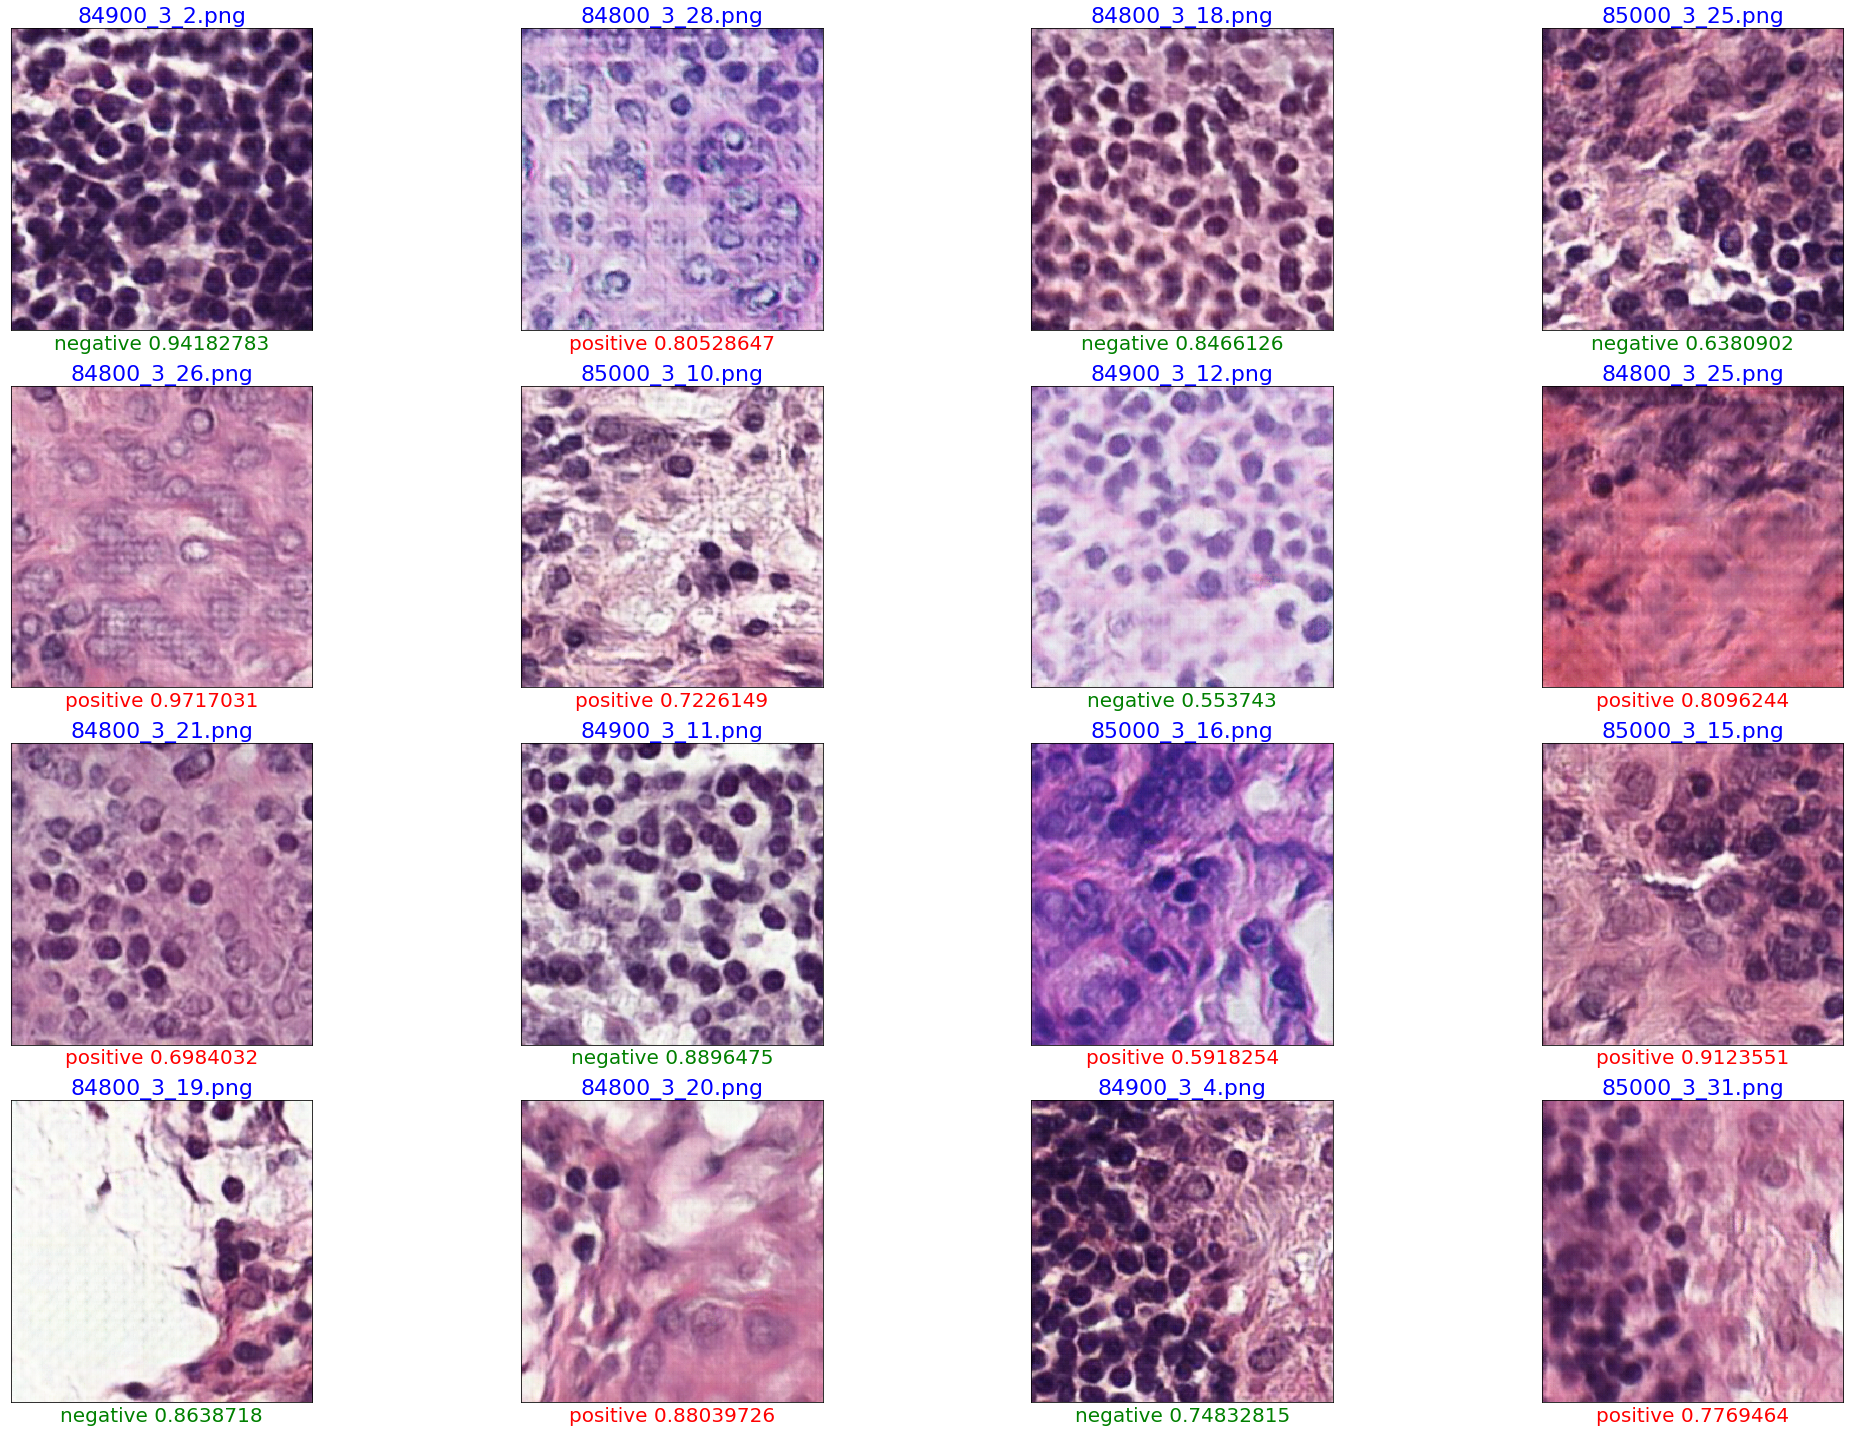

In [6]:
src_dir_train= constants.BASE_PATH + constants.DATA_PATH
src_dir_test= "test_images/histo_l0/evaluation/"
model="evaluation/trained_models/incp_v3_15k_l0_real.pb"
labels="evaluation/labels.txt"

#Reentrenar inception con todo el dataset puede tomar bastante tiempo
#se pueden obtener precisiones similares con un set mucho mas pequeño y 
#con la consecuente reducción de tiempo.
retrain_and_evaluate(src_dir_train, src_dir_test, model, labels, steps = 150, no_imgs_per_class = 100)

## Evaluacion de la red imagenes generadas a partir de la red entrenada con parches extraidos al nivel de zoom 1

In [23]:
dataset = "camelyon_17_16_level1"
change_active_config(dataset)
importlib.reload(constants)

<module 'constants' from '/home/ruben/Repositories/histo_bkp/histology_dcgan/constants.py'>

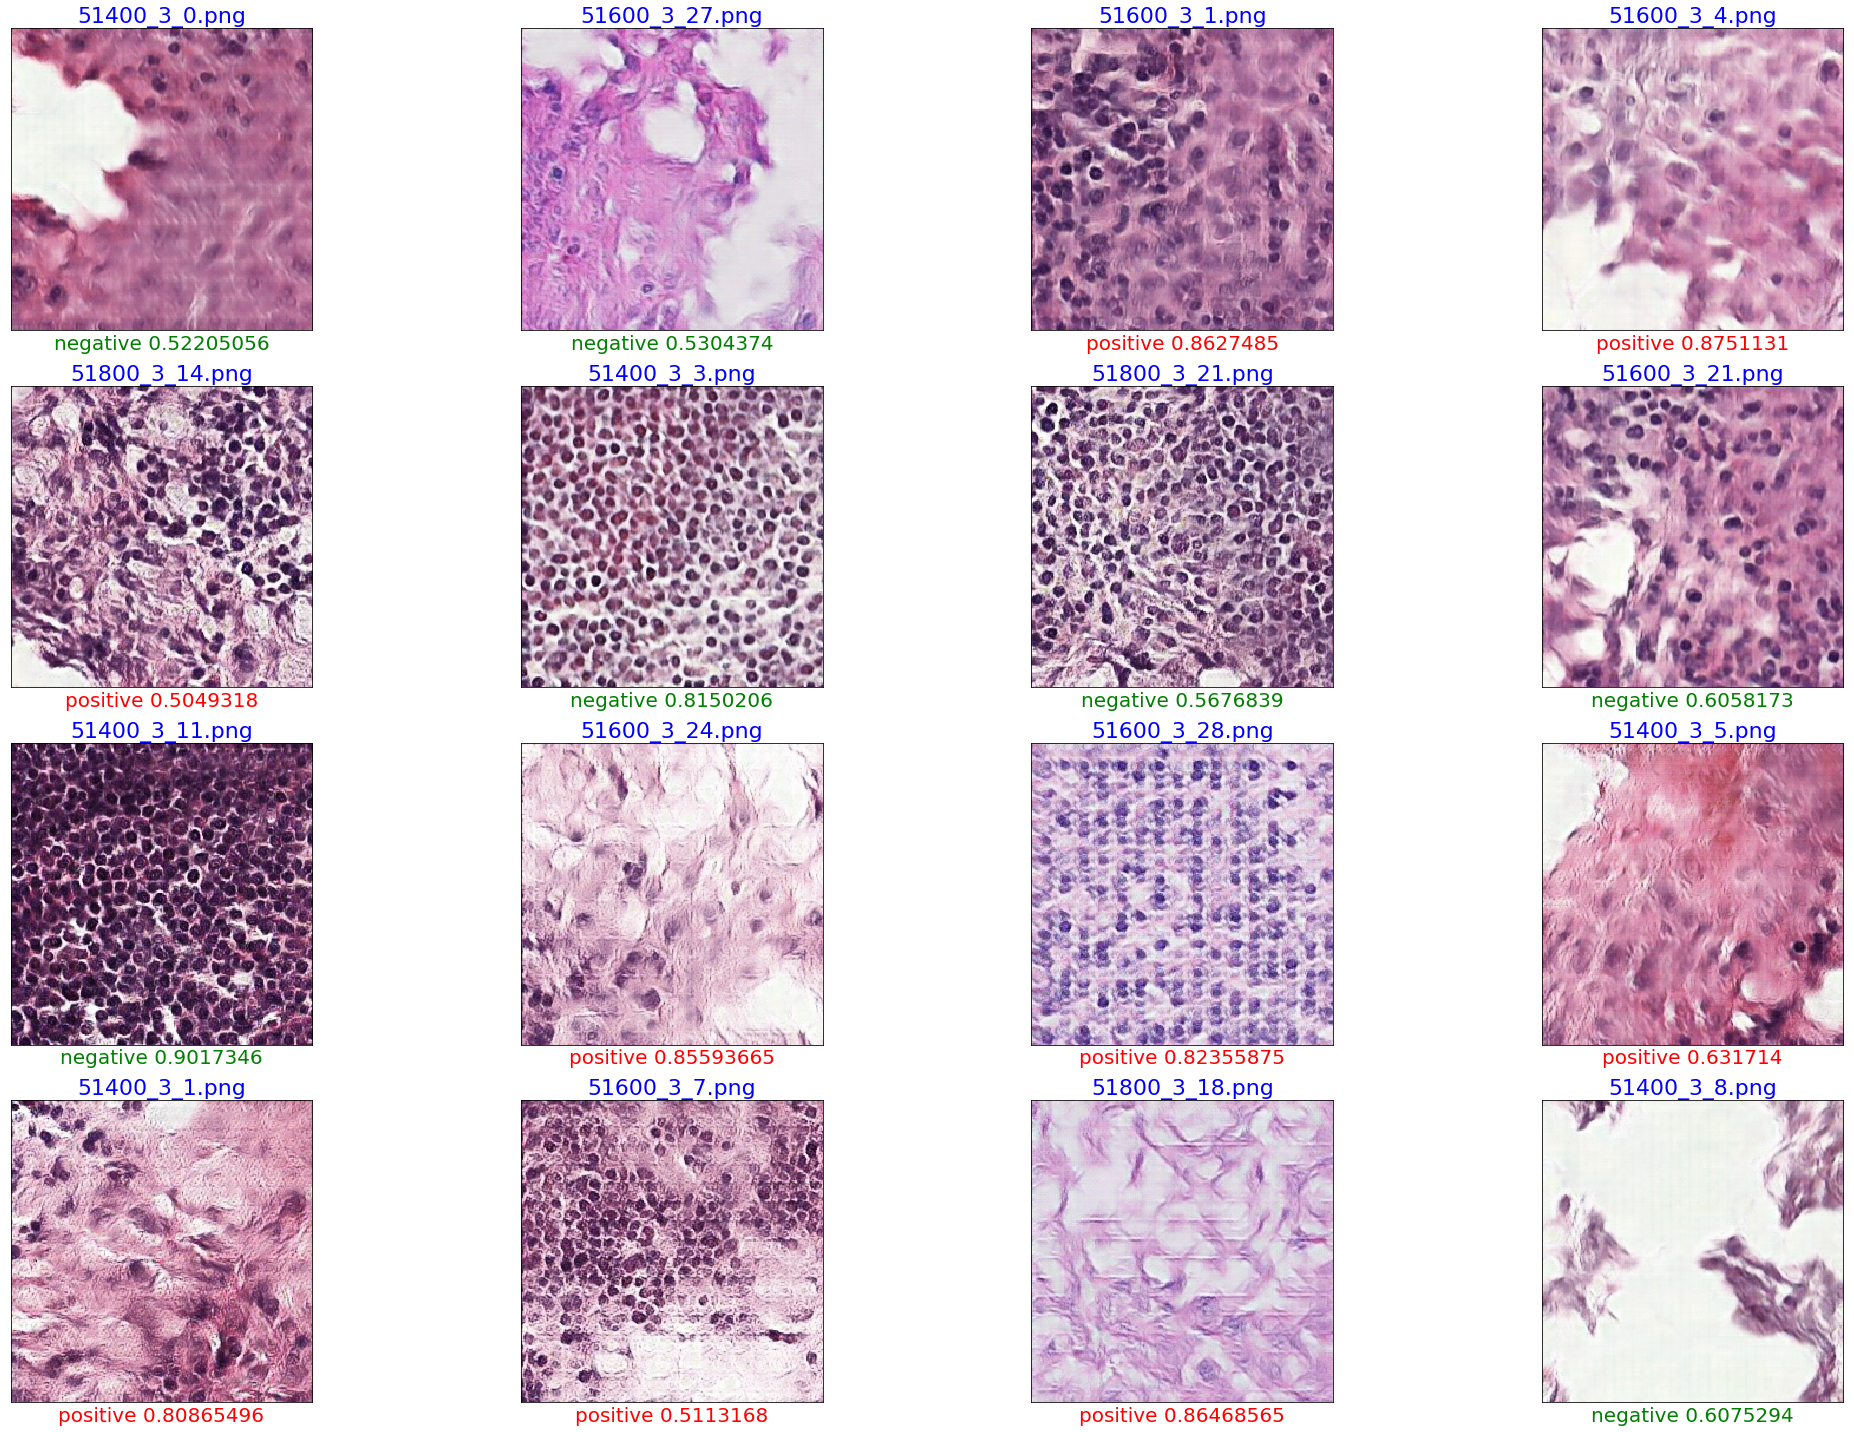

In [5]:
src_dir_train= constants.BASE_PATH + constants.DATA_PATH
src_dir_test= "test_images/histo_l1/evaluation/"
model="evaluation/trained_models/incp_v3_15k_l1_real.pb"
labels="evaluation/labels.txt"

#Reentrenar inception con todo el dataset puede tomar bastante tiempo
#se pueden obtener precisiones similares con un set mucho mas pequeño y 
#con la consecuente reducción de tiempo.
retrain_and_evaluate(src_dir_train, src_dir_test, model, labels, steps = 15000, no_imgs_per_class = 10000)


## Evaluacion de imagenes intermedias obtenidas de interpolaciones

No he tenido tiempo de hacer esta prueba aun

## Evaluacion de imagenes obtenidas a partir de operaciones con vectores conceptuales

No he tenido tiempo de hacer esta prueba aun